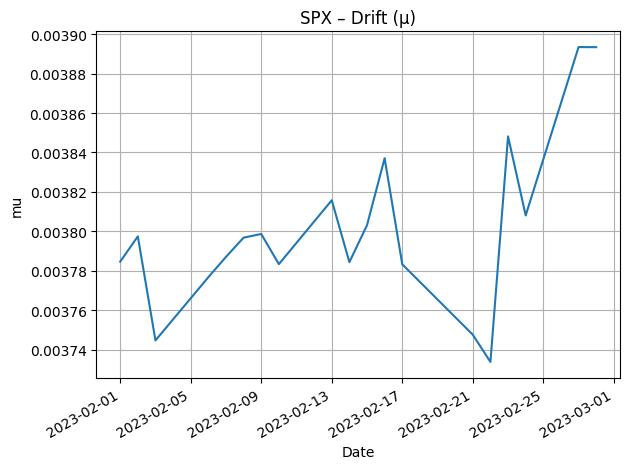

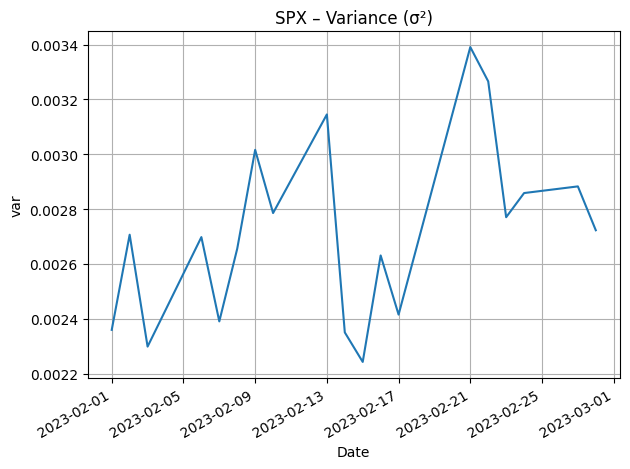

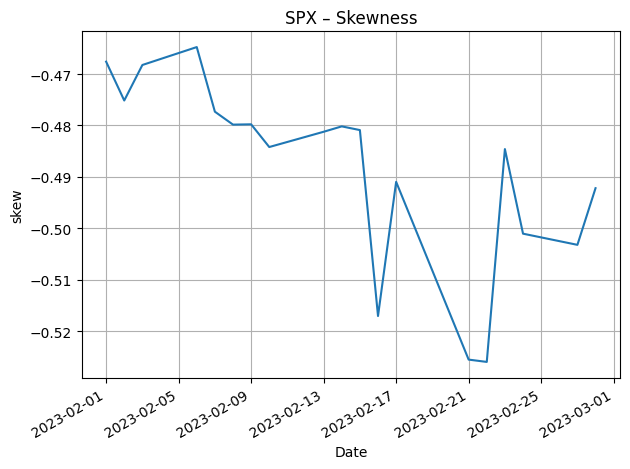

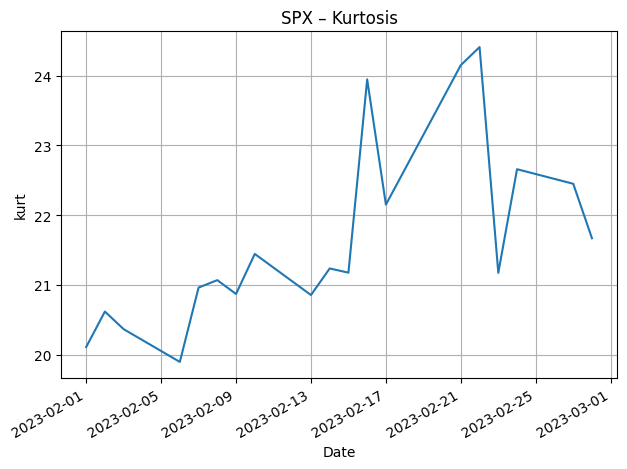

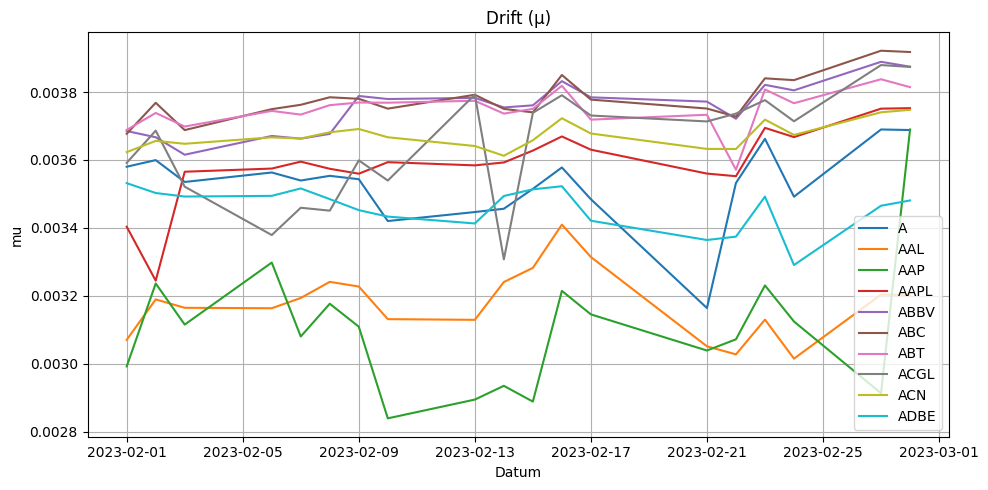

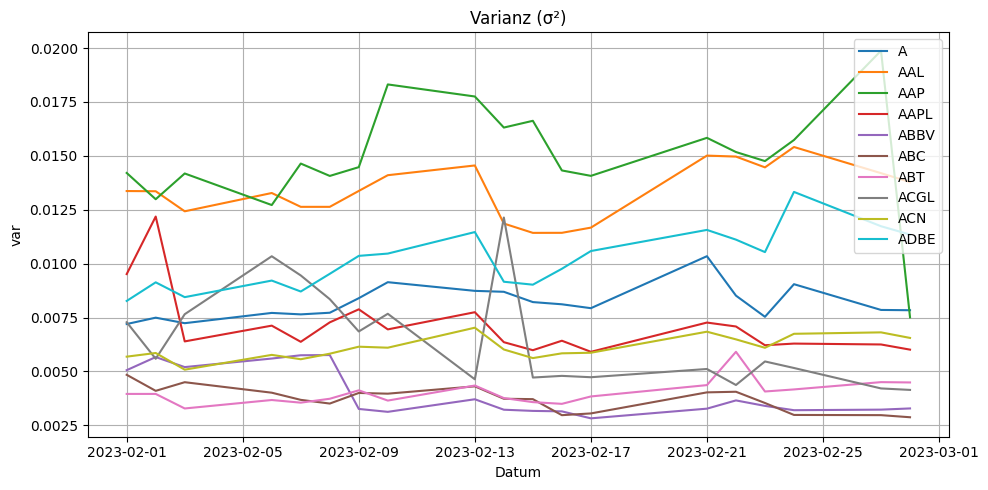

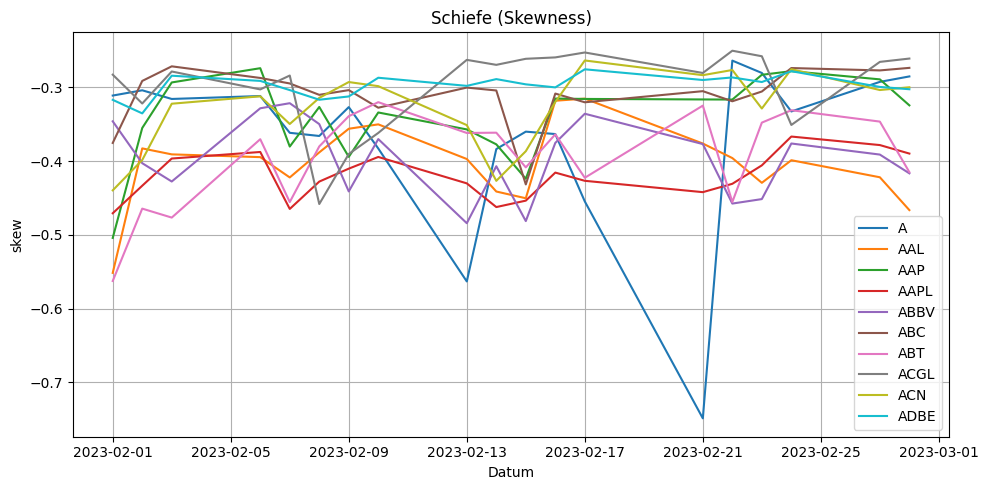

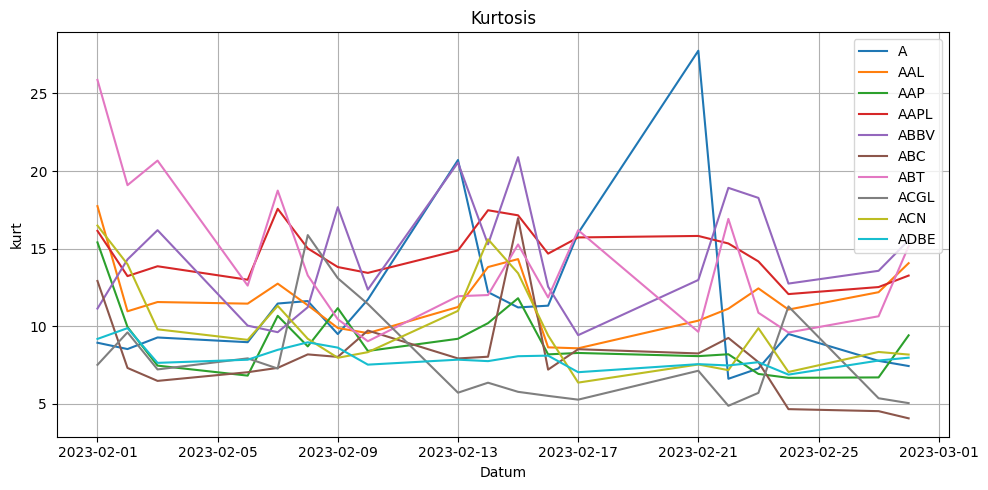

SPX rows after filter: 19


In [3]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from scipy.stats import norm
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------- Einstellungen --------------------------
TAU_DAYS = 30
MIND2E = 14
MAXD2E = 60
EPSILON = 1e-8
ROOT = Path('')

# --------------------- Black-Scholes Formel -------------------
def bs_price(S, K, r, q, vol, tau, flag):
    if vol <= 0 or tau <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * tau) / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    if flag == 'C':
        return np.exp(-q * tau) * S * norm.cdf(d1) - np.exp(-r * tau) * K * norm.cdf(d2)
    else:
        return np.exp(-r * tau) * K * norm.cdf(-d2) - np.exp(-q * tau) * S * norm.cdf(-d1)

# --------------------- Daten laden und vorbereiten ------------
rf = pd.read_csv(ROOT / 'riskfree_30d_2023-02.csv', parse_dates=['date'])
rf['rf_cc'] = rf['yld_pct_annual'] / 100

def preprocess(df):
    df = df.copy()
    df.rename(columns={
        'loctimestamp': 'date',
        'putcall': 'cp_flag',
        'implVol': 'iv',
        'daystomaturity': 'd2e',
        'Symbol': 'ticker',
        'underlyingprice': 'underlying_price'
    }, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['d2e'] = df['d2e'].astype(int)
    df = df.merge(rf[['date', 'rf_cc']], on='date', how='left')
    return df

spx = preprocess(pq.read_table(ROOT / 'spx_ivs_2023-02.parquet').to_pandas())
const = preprocess(pq.read_table(ROOT / 'sp500_merged_ivs_2023-02.parquet').to_pandas())


# --------------------- Berechnung BKM-Momente -----------------
def daily_moments(day_df, r, q, tau_yrs, debug=False):
    def calc_forward_and_q(df, r, tau):
        S = df['underlying_price'].iloc[0]
        calls = df[df['cp_flag'] == 'C']
        puts = df[df['cp_flag'] == 'P']
        strikes = np.intersect1d(calls['strike'], puts['strike'])
        if len(strikes) == 0:
            return S, 0.0
        K_star = strikes[np.argmin(np.abs(strikes - S))]
        iv_c = calls[calls['strike'] == K_star]['iv'].values[0]
        iv_p = puts[puts['strike'] == K_star]['iv'].values[0]
        C = bs_price(S, K_star, r, 0.0, iv_c, tau, 'C')
        P = bs_price(S, K_star, r, 0.0, iv_p, tau, 'P')
        F = K_star + np.exp(r * tau) * (C - P)
        q = r - np.log(F / S) / tau
        return F, q

    S = day_df['underlying_price'].iloc[0]
    F, q = calc_forward_and_q(day_df, r, tau_yrs)
    calls = day_df[(day_df['cp_flag'] == 'C') & (day_df['strike'] >= S)].copy()
    puts = day_df[(day_df['cp_flag'] == 'P') & (day_df['strike'] <= S)].copy()
    if len(calls) < 5 or len(puts) < 5:
        return np.nan, np.nan, np.nan, np.nan

    for df_opt, flag in ((calls, 'C'), (puts, 'P')):
        df_opt['price'] = [bs_price(S, K, r, q, vol, tau_yrs, flag) for K, vol in zip(df_opt['strike'], df_opt['iv'])]

    def trap(df, weight):
        df = df.sort_values('strike')
        K = df['strike'].values
        return simpson(df['price'].values * weight(K), K)

    V = trap(calls, lambda K: 2 / K**2) + trap(puts, lambda K: 2 / K**2)
    L = trap(calls, lambda K: np.log(K / F) / K**2) + trap(puts, lambda K: np.log(F / K) / K**2)
    W = trap(calls, lambda K: (np.log(K / F)**3 - 3*np.log(K / F)**2) / K**2) \
      - trap(puts, lambda K: (np.log(F / K)**3 + 3*np.log(F / K)**2) / K**2)
    X = trap(calls, lambda K: (np.log(K / F)**4 - 6*np.log(K / F)**3 + 12*np.log(K / F)**2) / K**2) \
      + trap(puts, lambda K: (np.log(F / K)**4 + 6*np.log(F / K)**3 + 12*np.log(F / K)**2) / K**2)

    mu = r * tau_yrs - L
    sigma2 = np.exp(r * tau_yrs) * V - mu**2
    if sigma2 < EPSILON:
        return mu, EPSILON, np.nan, np.nan

    skew = (np.exp(r*tau_yrs)*W - 3*mu*np.exp(r*tau_yrs)*V + 2*mu**3) / sigma2**1.5
    kurt = (np.exp(r*tau_yrs)*X - 4*mu*np.exp(r*tau_yrs)*W + 6*mu**2*np.exp(r*tau_yrs)*V - 3*mu**4) / sigma2**2
    return mu, sigma2, skew, kurt

# --------------------- Hauptloop: Momente berechnen ----------
records = []
for ticker, subset in [('SPX', spx)] + list(const.groupby('ticker')):
    for date, day in subset.groupby('date'):
        choices = day[(day['d2e'] >= MIND2E) & (day['d2e'] <= MAXD2E)]
        if choices.empty:
            continue
        idx = choices['d2e'].sub(TAU_DAYS).abs().idxmin()
        tau_yrs = choices.loc[idx, 'd2e'] / 365.0
        rf_cc = choices.loc[idx, 'rf_cc']
        mu, var, skew, kurt = daily_moments(
            day_df=choices[choices['d2e'] == choices.loc[idx, 'd2e']],
            r=rf_cc,
            q=0.0,
            tau_yrs=tau_yrs,
            debug=(ticker == 'SPX')
        )
        records.append(dict(date=date, ticker=ticker, mu=mu, var=var, skew=skew, kurt=kurt))

# --------------------- Ergebnisse und Bereinigung ------------
mom = pd.DataFrame.from_records(records).sort_values(['ticker', 'date'])
mom['log_kurt'] = np.where(mom['kurt'] > 0, np.log10(mom['kurt']), np.nan)
mom.to_csv(ROOT / 'bkm_moments_feb2023_raw.csv', index=False)

mom_clean = mom[
    ((mom['ticker'] != 'SPX') & (mom['var'] > 1e-7) & (mom['skew'].abs() < 1000) & (mom['kurt'].abs() < 10000)) |
    (mom['ticker'] == 'SPX')
]
mom_clean.to_csv(ROOT / 'bkm_moments_feb2023_cleaned.csv', index=False)

# --------------------- SPX-Export -----------------------------
spx = mom_clean[mom_clean['ticker'] == 'SPX']
for col in ['mu', 'var', 'skew', 'kurt']:
    spx[['date', col]].to_csv(ROOT / f'spx_{col}.csv', index=False)

# --------------------- Plots für SPX --------------------------
FIGS = {
    'mu': 'SPX – Drift (μ)',
    'var': 'SPX – Variance (σ²)',
    'skew': 'SPX – Skewness',
    'kurt': 'SPX – Kurtosis'
}
if not spx.empty:
    spx_plot = spx.set_index('date')
    for col, title in FIGS.items():
        if spx_plot[col].dropna().empty:
            continue
        plt.figure()
        spx_plot[col].plot(title=title)
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# --------------------- Plots für 10 Aktien --------------------
tickers = sorted([t for t in mom_clean['ticker'].unique() if t != 'SPX'])[:10]
data = {ticker: mom_clean[mom_clean['ticker'] == ticker].set_index('date')[['mu', 'var', 'skew', 'kurt']] for ticker in tickers}

for col, title in zip(['mu', 'var', 'skew', 'kurt'], ['Drift (μ)', 'Varianz (σ²)', 'Schiefe (Skewness)', 'Kurtosis']):
    plt.figure(figsize=(10, 5))
    for ticker in tickers:
        plt.plot(data[ticker].index, data[ticker][col], label=ticker)
    plt.title(title)
    plt.xlabel('Datum')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------------------- Einzelticker speichern -----------------
for ticker in mom_clean['ticker'].unique():
    mom_clean[mom_clean['ticker'] == ticker].to_csv(ROOT / f"moments_{ticker}.csv", index=False)

print("SPX rows after filter:", spx.shape[0])





for ticker in mom_clean['ticker'].unique():
    df = mom_clean[mom_clean['ticker'] == ticker].copy()
    df.set_index('date', inplace=True)
    for col in ['mu', 'var', 'skew', 'kurt']:
        if df[col].dropna().empty:
            continue
        plt.figure()
        df[col].plot(title=f'{ticker} – {col}')
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(ROOT / f'plot_{ticker}_{col}.png')
        plt.close()


In [4]:
df_test = pd.read_parquet(ROOT / 'spx_ivs_2023-02.parquet')
df_test.head()

,Symbol,loctimestamp,putcall,daystomaturity,implVol,implPrice,strike,forwardMoneyness,normalizedMoneyness,underlyingprice,underlyingforwardprice
0,^SPX,2023-02-01,P,30,0.546362,0.162479,2572.16,0.620158,-10.00,4138.45,4147.58
1,^SPX,2023-02-01,P,30,0.537310,0.176469,2603.06,0.627610,-9.75,4138.45,4147.58
2,^SPX,2023-02-01,P,30,0.528999,0.195240,2634.34,0.635152,-9.50,4138.45,4147.58
3,^SPX,2023-02-01,P,30,0.520193,0.214198,2666.00,0.642784,-9.25,4138.45,4147.58
4,^SPX,2023-02-01,P,30,0.510792,0.232522,2698.03,0.650507,-9.00,4138.45,4147.58
